# Setup

In [24]:
import pandas as pd
from google.colab import drive
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
!pip install twilio

from twilio.rest import Client

acct_sid = "AC4c79c8bfe3bc76d30ec9fc7cd68db52c"
auth_token = "733df99e4900399da63d0dbaaff7c07a"
to_phone = "+16085152900"
from_phone = "+12183963801"
client = Client(acct_sid, auth_token)

def send_text(message, client=client, to_phone=to_phone, from_phone=from_phone):
    client.messages.create(to=to_phone,
                           from_=from_phone,
                           body=message)

     |████████████████████████████████| 1.4 MB 26.4 MB/s 


In [5]:
def disp(df, n=5):
  print(df.shape)
  display(df.head(n))

In [30]:
drive.mount("/content/drive")
data_path = "/content/drive/MyDrive/data/final_project/"
num_tags = 50

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
questions = pd.read_csv(f"{data_path}Questions.csv", header=0, 
                        encoding="ISO-8859-1", engine="python", 
                        error_bad_lines=False)
# questions = pd.read_csv("Questions.csv", header=0, encoding="ISO-8859-1", 
#                         engine="python", error_bad_lines=False)
cols = {"Id": "id", "Title": "title", "Body": "body"}
questions = questions[cols.keys()].rename(columns=cols)

disp(questions)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


(1264216, 3)


,id,title,body
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [35]:
tags_long = pd.read_csv(f"{data_path}Tags.csv", header=0, encoding="ISO-8859-1",
                        engine="python", error_bad_lines=False)
top_tags = tags_long["Tag"].value_counts().head(num_tags).index
tags_long = tags_long[tags_long["Tag"].isin(top_tags)]

tags = tags_long.groupby("Id").agg(tuple).applymap(list).reset_index()
tags = tags.rename(columns={"Id": "id", "Tag": "tag"})

disp(tags)

(986641, 2)


,id,tag
0,120,"[sql, asp.net]"
1,260,"[c#, .net]"
2,330,[c++]
3,470,[.net]
4,580,[sql-server]


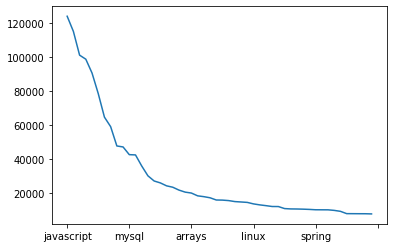

In [37]:
tags_long["Tag"].value_counts().plot()

In [40]:
df = questions.merge(tags, how="inner", on="id")

disp(df)

(986641, 4)


,id,title,body,tag
0,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
1,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
2,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,[c++]
3,470,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,[.net]
4,580,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,[sql-server]


In [41]:
for i in range(5):
  print(f"\n\n----TITLE {i}")
  print(df["title"].iloc[i])

  print(f"\n----BODY {i}")
  print(df["body"].iloc[i])

  print(f"\n----TAGS {i}")
  print(df["tag"].iloc[i])



----TITLE 0
ASP.NET Site Maps

----BODY 0
<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>

<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <strong>SiteMapPath</strong> controls, but I'll need a way for the users of my site to create and modify pages dynamically.</p>

<p>I need to tie page viewing permissions into the standard <code>ASP.NET</code> membership system as well.</p>


----TAGS 0
['sql', 'asp.net']


----TITLE 1
Adding scripting functionality to .NET applications

----BODY 1
<p>I have a little game written in C#. It uses a database as back-end. It's 
a <a href="http://en.wikipedia.org/wiki/Collectible_card_game">trading card game</a>, and I wanted to implement the function of the cards as a script.</p>

<p>What I mean is that I essentially have an interface, <code>ICard</code>, which a card class implements (<code>public class Card056 : ICard</code>) and which contains function that

# Ideas
- Oversampling to balance classes

# Preprocessing

In [42]:
disp(df)

(986641, 4)


,id,title,body,tag
0,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
1,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
2,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,[c++]
3,470,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,[.net]
4,580,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,[sql-server]


In [28]:
def process_text(text):
    stop = stopwords.words('english')
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word.lower() not in stop])

    return text

In [43]:
df['title_proc'] = df['title'].apply(process_text)

disp(df)

(986641, 5)


,id,title,body,tag,title_proc
0,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]",ASPNET Site Maps
1,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]",Adding scripting functionality NET applications
2,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,[c++],use nested classes case
3,470,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,[.net],Homegrown consumption web services
4,580,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,[sql-server],Deploying SQL Server Databases Test Live
